<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/My\ Drive/Colab\ Notebooks/
!ls
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from idlmam  import *

Mounted at /content/drive
drive  sample_data


/content/drive/My Drive/Colab Notebooks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import unicodedata
import string
from sklearn.metrics import accuracy_score


In [4]:
pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [5]:
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions")

# Check the dataset structure
print(dataset)
label_mapping = dataset["train"].features["labels"].feature.names
print(label_mapping)  # List of all emotion labels


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [6]:
emotion_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
  alphabet[all_letters[i]] = i


def unicodeToAscii(s):
    # Turns a Unicode string into plain ASCII
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

for sample in dataset["train"]:
    text = sample["text"]  # The text sample
    labels = sample["labels"]  # The list of labels for this sample

    # Normalize the text using the unicodeToAscii function
    normalized_text = unicodeToAscii(text).lower()

    # Loop through all labels for this sample (in case there are multiple labels)
    for label in labels:
        emotion = label_mapping[label]  # Map label index to emotion name

        # Add to the emotion_data dictionary
        if emotion not in emotion_data:
            emotion_data[emotion] = []  # Initialize the list for this emotion
        emotion_data[emotion].append(normalized_text)

# Print out the emotion names and their respective text count
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")

neutral: 14219 samples
anger: 1567 samples
fear: 596 samples
annoyance: 2470 samples
surprise: 1060 samples
gratitude: 2662 samples
desire: 641 samples
optimism: 1581 samples
admiration: 4130 samples
confusion: 1368 samples
amusement: 2328 samples
approval: 2939 samples
caring: 1087 samples
embarrassment: 303 samples
realization: 1110 samples
disappointment: 1269 samples
grief: 77 samples
sadness: 1326 samples
curiosity: 2191 samples
joy: 1452 samples
love: 2086 samples
excitement: 853 samples
disapproval: 2022 samples
remorse: 545 samples
disgust: 793 samples
relief: 153 samples
pride: 111 samples
nervousness: 164 samples


In [32]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
      self.label_names = [x for x in lang_name_dict.keys()]
      self.data = []
      self.labels = []
      self.vocabulary = vocabulary
      for y, language in enumerate(self.label_names):
          for sample in lang_name_dict[language]:
              if len(sample) > 0:  # Filter out empty inputs
                  self.data.append(sample)
                  self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """

        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label


In [33]:
dataset = LanguageNameDataset(emotion_data, alphabet)

# Limit the dataset size to 20,000 samples
total_size = min(len(dataset), 20000)  # Use the smaller of the dataset size or 20,000

# Define proportions
train_ratio = 0.8  # 80% training
test_ratio = 0.2   # 20% testing

# Compute split sizes
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Take a subset of the dataset if the dataset is larger than 20,000
subset_indices = torch.randperm(len(dataset))[:total_size]  # Randomly select 20,000 indices
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

# Randomly split the subset dataset
train_data, test_data = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [34]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)


torch.Size([5]) torch.Size([5, 2])
tensor([[ 2.0295, -1.1324],
        [-1.3146, -0.2999],
        [-1.3146, -0.2999],
        [ 2.0295, -1.1324],
        [-0.0420, -0.1619]])


In [35]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple,
            last_step = last_step[0]#then h_t is the first item in the tuple

        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)


In [36]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)


In [37]:
for batch in train_loader:
    input_data, labels = batch
    print(input_data.shape)
    break


torch.Size([1, 132])


In [30]:
for idx, data in enumerate(train_data):
    input_vec, label = data
    if len(input_vec) == 0:
        print(f"Empty input found at index {idx}")


Empty input found at index 15515


In [38]:
loss_func = nn.CrossEntropyLoss()
device = "cuda"
batch_one_train = train_simple_network(first_rnn, \
              loss_func, train_loader, \
              test_loader=test_loader, \
              score_funcs={'Accuracy': accuracy_score},\
              device=device, epochs=20)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

Training:   0%|          | 0/16000 [00:00<?, ?it/s]

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

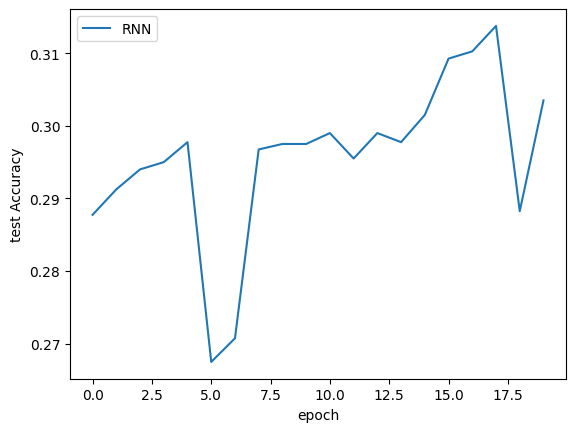

In [39]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')